Copy of 4 with L2 regularization on the latent space

In [1]:
AEversion = '5'

In [2]:
import numpy as np
import os, sys, pickle
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [3]:
import gpustat
try:
    gpustat.print_gpustat()
except:
    pass

imperium-sm.hep.caltech.edu  Wed Jul 10 08:14:53 2019
[0] GeForce GTX 1080 | 22'C,   0 % |    11 /  8119 MB |
[1] GeForce GTX 1080 | 23'C,   0 % |  7816 /  8119 MB | ocerri(7805M)
[2] GeForce GTX 1080 | 26'C,   0 % |    10 /  8119 MB |
[3] GeForce GTX 1080 | 23'C,   0 % |    11 /  8119 MB |
[4] GeForce GTX 1080 | 27'C,   0 % |    11 /  8119 MB |
[5] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 57'C,  16 % |  2794 /  8119 MB | ocerri(2783M)
[7] GeForce GTX 1080 | 27'C,   0 % |    11 /  8119 MB |


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
sys.path.append('../lib')
from progressBar import ProgressBar
from utils import EarlyStopping, createROC_curve, ELU_ProbNorm

In [6]:
dnd = []

## Get the dataset

In [7]:
from dataLoaders import ParticleDataset

In [8]:
dataset = ParticleDataset(template='../data/20190708_50part_PtOrder_v2/{}.npy', N_part=20, N_features=5)

In [9]:
dataset.loadTrainSM(N_train_max=1e7)
dataset.charge(dataset.SMMix_train)

Fetching Wlnu
Fetching qcd
Fetching Zll
Fetching ttbar
QCD is limiting, using it for both val and split
Expected 3.38M train
Expected 3.38M val

Loading Wlnu
Reloading QCD for validation
Loading Zll
Loading ttbar
+--------+----------+-------+-------+
| Sample | Evts tot | Train |  Val  |
+--------+----------+-------+-------+
|  Wlnu  |  4000k   | 2000k | 2000k |
|  qcd   |  1166k   | 1142k | 1142k |
|  Zll   |  1000k   |  226k |  226k |
| ttbar  |  1000k   |  10k  |  10k  |
+--------+----------+-------+-------+
Tot training 3.38 M
Tot val 3.38 M


In [10]:
dataset.loadValidationSamples('BSM')

Loading Ato4l (47.7k)
Loading leptoquark (273.6k)
Loading hToTauTau (681.8k)
Loading hChToTauNu (338.5k)


## Define the model

In [11]:
class AEDenseNet(nn.Module):
    def __init__(self, N_part, N_features, dim_hidden, dim_latent, verbose = False):
        super(AEDenseNet, self).__init__()
        self.verbose = verbose
        
        self.No = N_part
        self.p = N_features
        self.Nk = dim_latent
        
        self.encoder_modules = nn.ModuleDict({
            'PhiE': self.build_dense(dim_in=self.p*self.No,
                                   dim_out=self.Nk,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.decoder_modules = nn.ModuleDict({
            'PhiD': self.build_dense(dim_in=self.Nk,
                                   dim_out=(self.p+3)*self.No,
                                   dim_hidden=dim_hidden),
            'ChargeDec': self.build_dense(dim_in=2,
                                   dim_out=3),
            'pdgIdDec': self.build_dense(dim_in=2,
                                   dim_out=5)
        })
        
        
        self.onGPU = False
          
    def build_dense(self, dim_in, dim_out, dim_hidden=0):
        if dim_hidden:
            net = nn.Sequential(
                                nn.Linear(dim_in, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_out),
                              )
        else:
            d_avg = int(0.5*(dim_in + dim_out))
            net = nn.Sequential(
                                nn.Linear(dim_in, d_avg),
                                nn.ReLU(),
                                nn.Linear(d_avg, dim_out),
                              )
        return net
        
    def encode(self, x):
        z_raw = self.encoder_modules['PhiE'](x.contiguous().view(-1, self.p*self.No))
        z = F.hardtanh(z_raw, min_val=-10, max_val=10)
        return z_raw
    
    def decode(self, z):
        x_raw = self.decoder_modules['PhiD'](z).view(-1, self.No, self.p+3)
        
        # --- Formatting x ----
        # pt
        pt = 1. + F.elu(x_raw[:,:,0]).view(-1, self.No, 1)
        sig_pt = 1. + 1e-6 + F.elu(x_raw[:,:,1]).view(-1, self.No, 1)
        # eta
        eta = F.hardtanh(x_raw[:,:,2], min_val=-5, max_val=5).view(-1, self.No, 1)
        sig_eta = 1. + 1e-6 + F.elu(x_raw[:,:,3]).view(-1, self.No, 1)
        # phi
        phi = torch.fmod(torch.abs(x_raw[:,:,4]), 6.2831853072).view(-1, self.No, 1) - 3.14159265359
        sig_phi = 1. + 1e-6 + F.elu(x_raw[:,:,5]).view(-1, self.No, 1)
        # charge
#         charge_cat = F.softmax(self.decoder_modules['ChargeDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 3)
        charge_cat = ELU_ProbNorm(self.decoder_modules['ChargeDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 3)
        # pId
#         pId_cat = F.softmax(self.decoder_modules['pdgIdDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 5)
        pId_cat = ELU_ProbNorm(self.decoder_modules['pdgIdDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 5)
        
        x = torch.cat((pt, eta, phi, sig_pt, sig_eta, sig_phi, charge_cat, pId_cat), 2)
        return x
        
    
    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime
    
    def initWeights(self):
        def weights_init(M):
            if hasattr(M, 'weight'):
                nn.init.xavier_normal_(M.weight.data)
        
        self.apply(weights_init)
    
    def useGPU(self, N_GPU=1):
        if torch.cuda.is_available():
            print('Current device: {} ({} available)'.format(torch.cuda.current_device(), 
                                                             torch.cuda.device_count()))
            os.environ['CUDA_VISIBLE_DEVICES'] = str(N_GPU)
            self.N_GPU = N_GPU
            torch.cuda.empty_cache()
            self.cuda(N_GPU)
            gpustat.print_gpustat()
            
            self.onGPU = True
        else: 
            print('GPU not available')

In [12]:
Latent_dimension = int(0.6*dataset.inputs.shape[1])
Hidden_dimension = int(0.5*(Latent_dimension + dataset.inputs.shape[1]*dataset.inputs.shape[2]))

model = AEDenseNet(
                   N_part=dataset.inputs.shape[1],
                   N_features=dataset.inputs.shape[2],
                   dim_hidden=Hidden_dimension,
                   dim_latent=Latent_dimension
                  )

print(model)
trainablePars = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nTrainable parameters:', trainablePars)

# model.initWeights()

AEDenseNet(
  (encoder_modules): ModuleDict(
    (PhiE): Sequential(
      (0): Linear(in_features=100, out_features=56, bias=True)
      (1): ReLU()
      (2): Linear(in_features=56, out_features=56, bias=True)
      (3): ReLU()
      (4): Linear(in_features=56, out_features=12, bias=True)
    )
  )
  (decoder_modules): ModuleDict(
    (ChargeDec): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=3, bias=True)
    )
    (PhiD): Sequential(
      (0): Linear(in_features=12, out_features=56, bias=True)
      (1): ReLU()
      (2): Linear(in_features=56, out_features=56, bias=True)
      (3): ReLU()
      (4): Linear(in_features=56, out_features=160, bias=True)
    )
    (pdgIdDec): Sequential(
      (0): Linear(in_features=2, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=5, bias=True)
    )
  )
)

Trainable parameters: 22616


In [13]:
model.useGPU(int(AEversion))

Current device: 0 (8 available)
imperium-sm.hep.caltech.edu  Wed Jul 10 08:15:26 2019
[0] GeForce GTX 1080 | 23'C,   0 % |    11 /  8119 MB |
[1] GeForce GTX 1080 | 23'C,   0 % |  7816 /  8119 MB | ocerri(7805M)
[2] GeForce GTX 1080 | 26'C,   0 % |    10 /  8119 MB |
[3] GeForce GTX 1080 | 23'C,   0 % |    11 /  8119 MB |
[4] GeForce GTX 1080 | 27'C,   0 % |    11 /  8119 MB |
[5] GeForce GTX 1080 | 27'C,   3 % |   468 /  8119 MB | ocerri(457M)
[6] GeForce GTX 1080 | 58'C,  86 % |  2794 /  8119 MB | ocerri(2783M)
[7] GeForce GTX 1080 | 27'C,   0 % |    11 /  8119 MB |


## Loss

In [14]:
def criterion(x_in, x_out, z, reduction='mean'):
    # Gaussian
    out_gauss = torch.pow((x_in[:,:,:3] - x_out[:,:,:3])/ x_out[:,:,3:6], 2) + torch.log(x_out[:,:,3:6])
    out = torch.sum(out_gauss, dim=2)
    
    #Cat cross entropy charge
    aux = torch.log(x_out[:,:,6:9]).view(-1, 3)
    aux = F.nll_loss(aux, 1+x_in[:,:,3].view(-1).long(), reduction='none')
    out += aux.view(-1, x_in.shape[1])
    
    #Cat cross entropy pId
    aux = torch.log(x_out[:,:,9:14]).view(-1, 5)
    out += F.nll_loss(aux, x_in[:,:,4].view(-1).long(), reduction='none').view(-1, x_in.shape[1])
    
    out_per_evt = torch.sum(out, dim=1)
    
    #Gaussian Likelihood for latent space
    out_per_evt += torch.sum(torch.mul(z,z), dim=-1)
    
    if reduction == 'mean':
        return torch.mean(out_per_evt)
    elif reduction == 'none':
        return out_per_evt
    else:
        raise

## Training

In [15]:
training_params = {'batch_size': 10000,
                   'shuffle': True,
                   'num_workers': 3
                  }

max_epochs = 500

eval_params = {'batch_size': 50000,
               'num_workers': 3
              }

In [16]:
# torch.autograd.set_detect_anomaly(True);

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2,
                              min_lr=1e-7
                             )

# Early stopping
earlyStopping = EarlyStopping(patient=10)

In [18]:
train_loss = []
BSM_eff = {'ep': []}
for n in dataset.BSM_names:
    BSM_eff[n] = []

loss_history = {'train': [], 'val': []}
optimizer.zero_grad()
try:
    for epoch in range(max_epochs):
        batch_loss = []

        #### ---- Training ---- ####
        model.train()
        dataset.charge(dataset.SMMix_train)
        train_data_iter = torch.utils.data.DataLoader(dataset, **training_params)
        pb = ProgressBar(len(train_data_iter), percentPrecision=5, headLabel='Epoch {}: '.format(epoch))
        for local_x, _ in train_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)

            x_prime = model(local_x)   
            z = model.encode(local_x)
            loss = criterion(local_x, x_prime, z)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print('Invalid training loss!!!')
                raise NameError('LossNAN')
            batch_loss.append(loss.item())

            tail_label = 'Loss: {:2.2e}'.format(loss.item())
            if len(loss_history['train']) > 0:
                tail_label += ' ({:2.2e})'.format(loss.item() - loss_history['train'][-1][-1])
            pb.show(len(batch_loss)-1, tail_label=tail_label)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        aux_loss = 0
        N_batches = 0
        for local_x, _ in train_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)
            x_prime = model(local_x)
            z = model.encode(local_x)
            loss = criterion(local_x, x_prime, z)
            aux_loss += loss.item()
            N_batches += 1
        batch_loss.append(aux_loss/N_batches)

        printout = 'Loss: {:2.2e}'.format(batch_loss[-1])
        if len(loss_history['train']) > 0:
            printout += ' - Delta: {:2.2e}'.format(batch_loss[-1] - loss_history['train'][-1][-1])
        if len(loss_history['train']) > 1:
            d2L_de2 = batch_loss[-1] - 2*loss_history['train'][-1][-1] + loss_history['train'][-2][-1]
            printout +=' - Trend: {:2.2e}'.format(d2L_de2)
        print(printout)

        loss_history['train'].append(batch_loss)

        #### ---- Validation ---- ####
        dataset.charge(dataset.SMMix_val)
        val_data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
        aux_loss = 0
        N_batches = 0
        for local_x, _ in val_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)
            x_prime = model(local_x)
            z = model.encode(local_x)
            loss = criterion(local_x, x_prime, z)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print('Invalid validation loss!!!')
                raise NameError('LossNAN')
            aux_loss += loss.item()
            N_batches += 1
        loss_history['val'].append(aux_loss/N_batches)
        printout = 'Val Loss: {:2.2e}'.format(loss_history['val'][-1])
        print(printout)
        if epoch > 0:
            if loss_history['val'][-1] < np.min(loss_history['val']):
                print('[INFO]: Saving best model')
                torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'_best.pkl')

        print('')
        if not earlyStopping.check(loss_history['val'][-1]):
            break

        scheduler.step(batch_loss[-1])

        #### ---- Anomaly Detection monitor ---- ####
        if epoch%3 == 0:
            print('------------ Anomaly Detection monitor ------------')
            BSM_eff['ep'].append(epoch)
            dataset.loss['SMMix'] = np.zeros((0))

            pb = ProgressBar(len(val_data_iter), percentPrecision=5, headLabel='SM Mix: ')
            for i, (local_x, _) in enumerate(val_data_iter):
                    pb.show(i)
                    if model.onGPU:
                        local_x = local_x.cuda(model.N_GPU)

                    x_prime = model(local_x)
                    z = model.encode(local_x)
                    loss = criterion(local_x, x_prime, z, 'none').cpu().detach().numpy()
                    dataset.loss['SMMix'] = np.concatenate((dataset.loss['SMMix'], loss))

            p_SM = np.logspace(base=10, start=-5, stop=-3, num=3)
            if not 'p_SM' in BSM_eff.keys():
                BSM_eff['p_SM'] = p_SM
            q_SM = np.quantile(dataset.loss['SMMix'], 1-p_SM)

            table = PrettyTable(['SM Mix'] + list(map(lambda x: '{:1.2e}'.format(x), p_SM)))

            for n in dataset.BSM_names:
                dataset.loss[n] = np.zeros((0))

                dataset.charge(dataset.valSamples[n])
                data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
                pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
                for i, (local_x, _) in enumerate(data_iter):
                    pb.show(i)
                    if model.onGPU:
                        local_x = local_x.cuda(model.N_GPU)

                    x_prime = model(local_x)
                    z = model.encode(local_x)
                    loss = criterion(local_x, x_prime, z, 'none').cpu().detach().numpy()
                    dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

                out = dataset.loss[n] > np.atleast_2d(q_SM).T
                p_BSM = np.float64(np.sum(out, axis=1, dtype=np.float128)/dataset.loss[n].shape[0])
                BSM_eff[n].append(p_BSM)

                table.add_row([n] + list(map(lambda x: '{:1.2e}'.format(x), p_BSM)))
            print(table)                
            print('---------------------------------------------------\n\n')

    model.eval()
    torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'.pkl');
except NameError:
    if epoch > 0:
        print ('\n\nModel ended up nan. Recovering best model\n')
        model.load_state_dict(torch.load('data/model_state_dict_dAE_v'+AEversion+'_best.pkl'))
    else:
        raise

Epoch 0: [####################]  100% - Tot. time: 16.2 s           
Loss: 6.53e+05
Val Loss: 5.99e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 19.0 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.6 s
hToTauTau: [##############]  100% - Tot. time: 3.0 s
hChToTauNu: [#######]  100% - Tot. time: 1.0 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 6.29e-05 | 1.03e-03 | 2.01e-02 |
| leptoquark | 8.77e-05 | 1.33e-03 | 1.65e-02 |
| hToTauTau  | 7.38e-04 | 6.75e-03 | 4.39e-02 |
| hChToTauNu | 1.35e-03 | 1.14e-02 | 6.11e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 1: [####################]  100% - Tot. time: 16.1 s                       
Loss: 3.39e+03 - Delta: -6.50e+05
Val Loss: 5.87e+01

Epoch 2: [--------------------] 

Epoch 364: [####################]  100% - Tot. time: 16.2 s                       
Loss: 1.50e+01 - Delta: -9.19e-03 - Trend: 5.91e-03
Val Loss: 1.55e+01

Epoch 365: [####################]  100% - Tot. time: 15.7 s                       
Loss: 1.50e+01 - Delta: -7.35e-03 - Trend: 1.84e-03
Val Loss: 1.55e+01

Epoch 366: [####################]  100% - Tot. time: 16.1 s                       
Loss: 1.50e+01 - Delta: 2.75e-03 - Trend: 1.01e-02
Val Loss: 1.55e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 18.6 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.5 s
hToTauTau: [#####---------]  35% - ETA:    2 s   Val Loss: 1.55e+01

Epoch 369: [####################]  100% - Tot. time: 15.8 s                       
Loss: 1.50e+01 - Delta: -1.58e-03 - Trend: -2.40e-03
Val Loss: 1.55e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 22.2 s
Ato4l: [#] 

Epoch 388: [####################]  100% - Tot. time: 16.2 s                       
Loss: 1.49e+01 - Delta: -3.76e-01 - Trend: -7.44e-01
Val Loss: 1.54e+01

Epoch 389: [####################]  100% - Tot. time: 16.2 s                       
Loss: 1.49e+01 - Delta: 5.77e-03 - Trend: 3.82e-01
Val Loss: 1.54e+01

Epoch 390: [####################]  100% - Tot. time: 18.7 s                       
Loss: 1.49e+01 - Delta: -9.83e-03 - Trend: -1.56e-02
Val Loss: 1.54e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 18.7 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.6 s
hToTauTau: [##############]  100% - Tot. time: 3.0 s
hChToTauNu: [#######]  100% - Tot. time: 1.0 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 4.28e-03 | 3.77e-02 |
| leptoquark | 1.10e-05 | 5.12e-04 | 1.25e-02 |
| h

Epoch 409: [####################]  100% - Tot. time: 35.0 s                       
Loss: 1.48e+01 - Delta: -5.01e-03 - Trend: 1.03e-02
Val Loss: 1.54e+01

Epoch 410: [####################]  100% - Tot. time: 18.8 s                       
Loss: 1.48e+01 - Delta: 2.35e-02 - Trend: 2.86e-02
Val Loss: 1.54e+01

Epoch 411: [####################]  100% - Tot. time: 23.0 s                       
Loss: 1.48e+01 - Delta: -2.18e-02 - Trend: -4.53e-02
Val Loss: 1.54e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 24.8 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.6 s
hToTauTau: [##############]  100% - Tot. time: 3.5 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 4.42e-03 | 3.78e-02 |
| leptoquark | 7.31e-06 | 5.15e-04 | 1.26e-02 |
| hT

Epoch 430: [####################]  100% - Tot. time: 16.2 s                       
Loss: 1.47e+01 - Delta: -5.35e-03 - Trend: 1.71e-03
Val Loss: 1.53e+01

Epoch 431: [####################]  100% - Tot. time: 16.4 s                       
Loss: 1.47e+01 - Delta: 4.93e-03 - Trend: 1.03e-02
Val Loss: 1.53e+01

Epoch 432: [####################]  100% - Tot. time: 16.2 s                       
Loss: 1.47e+01 - Delta: -8.72e-03 - Trend: -1.37e-02
Val Loss: 1.53e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 19.8 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.7 s
hToTauTau: [##############]  100% - Tot. time: 3.7 s
hChToTauNu: [#######]  100% - Tot. time: 1.0 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 4.57e-03 | 3.78e-02 |
| leptoquark | 3.65e-06 | 5.45e-04 | 1.26e-02 |
| hT

leptoquark: [######]  100% - Tot. time: 0.6 s
hToTauTau: [##############]  100% - Tot. time: 3.0 s
hChToTauNu: [#######]  100% - Tot. time: 1.1 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 4.59e-03 | 3.78e-02 |
| leptoquark | 3.65e-06 | 5.34e-04 | 1.25e-02 |
| hToTauTau  | 2.05e-05 | 9.61e-04 | 2.71e-02 |
| hChToTauNu | 5.02e-05 | 1.20e-03 | 3.49e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 454: [####################]  100% - Tot. time: 16.3 s                       
Loss: 1.47e+01 - Delta: 2.89e-04 - Trend: 5.74e-03
Val Loss: 1.52e+01

Epoch 455: [####################]  100% - Tot. time: 16.3 s                       
Loss: 1.47e+01 - Delta: -1.08e-03 - Trend: -1.37e-03
Val Loss: 1.52e+01

Epoch 456: [####################]  100% - Tot. time: 16.9 s                       
Loss: 1.46e+01 - Delta:

Epoch 474: [####################]  100% - Tot. time: 16.2 s                       
Loss: 1.46e+01 - Delta: -4.22e-03 - Trend: -2.77e-03
Val Loss: 1.52e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 19.0 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.6 s
hToTauTau: [##############]  100% - Tot. time: 3.1 s
hChToTauNu: [#######]  100% - Tot. time: 1.1 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 4.59e-03 | 3.78e-02 |
| leptoquark | 3.65e-06 | 5.23e-04 | 1.25e-02 |
| hToTauTau  | 2.05e-05 | 9.30e-04 | 2.71e-02 |
| hChToTauNu | 5.02e-05 | 1.17e-03 | 3.48e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 475: [####################]  100% - Tot. time: 17.2 s                       
Loss: 1.46e+01 - Delta: -2.71e-0

Epoch 494: [####################]  100% - Tot. time: 23.9 s                       
Loss: 1.46e+01 - Delta: 8.36e-05 - Trend: 4.40e-01
Val Loss: 1.52e+01

Epoch 495: [####################]  100% - Tot. time: 21.6 s                       
Loss: 1.46e+01 - Delta: -4.64e-03 - Trend: -4.73e-03
Val Loss: 1.52e+01

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 23.7 s
Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 1.0 s
hToTauTau: [##############]  100% - Tot. time: 7.3 s
hChToTauNu: [#######]  100% - Tot. time: 1.1 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 4.42e-03 | 3.76e-02 |
| leptoquark | 3.65e-06 | 5.15e-04 | 1.24e-02 |
| hToTauTau  | 2.05e-05 | 9.02e-04 | 2.68e-02 |
| hChToTauNu | 4.73e-05 | 1.14e-03 | 3.45e-02 |
+------------+----------+----------+----------+
---------------

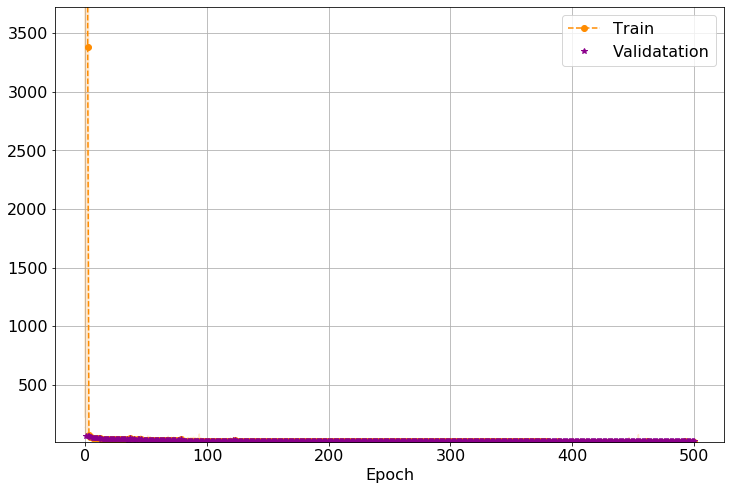

In [19]:
loss_history['train'] = np.array(loss_history['train'])
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(12,8))

train_loss_flat = loss_history['train'].flatten()
x = np.arange(1, train_loss_flat.shape[0]+1) * float(loss_history['train'].shape[0])/train_loss_flat.shape[0]
plt.plot(x, train_loss_flat, '-', alpha=0.2, color='darkorange')

x = np.arange(1, loss_history['train'].shape[0]+1)
plt.plot(x, loss_history['train'][:,-1], 'o--', label='Train', color='darkorange')
plt.plot(x, loss_history['val'], '*', label='Validatation', color='darkmagenta')

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')
# plt.yscale('log')
plt.ylim(0.9*np.min(train_loss_flat), 1.1*np.max(loss_history['train'][1:, -1]))

f.savefig('plots/TrainingHistory_dAE_v'+AEversion+'.png')

f = open('data/TrainingHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(loss_history, f)
f.close()

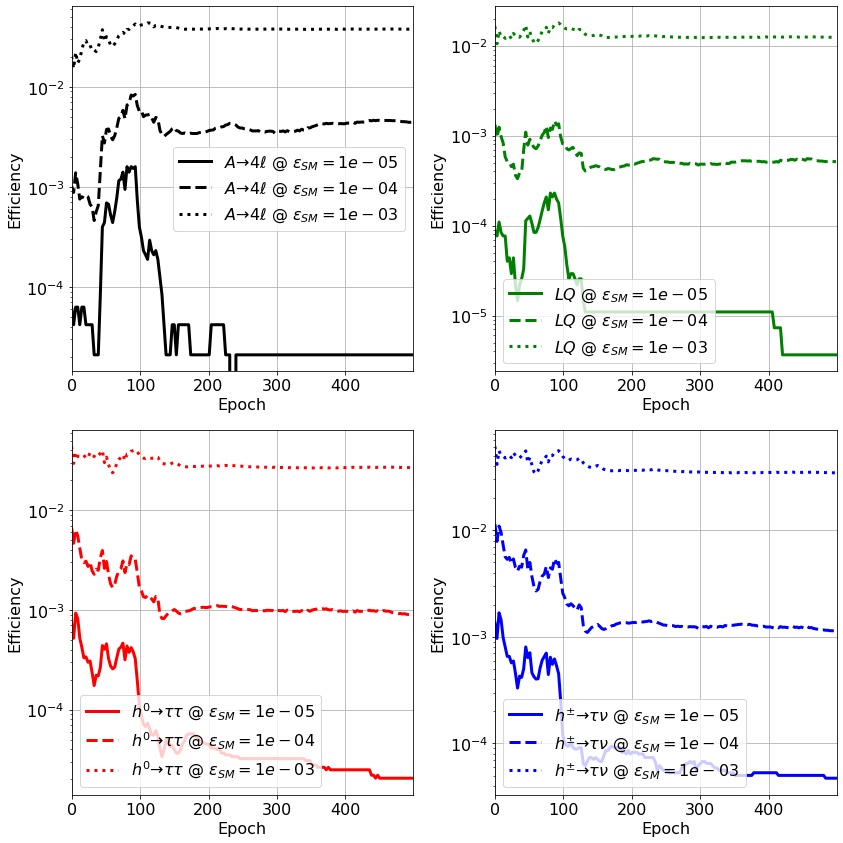

In [20]:
f, ax_arr = plt.subplots(2,2, figsize=(12,12))
styles = ['-', '--', ':']
x = BSM_eff['ep']
for i, n in enumerate(dataset.BSM_names):  
    ax = ax_arr[int(i/2),i%2]
    
    BSM_eff[n] = np.array(BSM_eff[n])
    
    for j in range(BSM_eff['p_SM'].shape[0]):
#         ax.plot(x, len(x)*[BSM_eff['p_SM'][j]], color='gray', lw=2, linestyle=styles[j])
        ax.plot(x, BSM_eff[n][:,j], 
                color=dataset.process_colors[n], lw=3, linestyle=styles[j], 
                label=dataset.process_labels[n] + ' @ $\epsilon_{{SM}} = {:1.0e}$'.format(BSM_eff['p_SM'][j]))
        
    ax.set_xlim([0, x[-1]+1])
#     ax.set_ylim([1e-6, 5])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.grid()
    
    ax.legend(loc='best')
    
f.tight_layout()

f = open('data/AnomalyDetectionHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(BSM_eff, f)
f.close()

# Convergence check

In [21]:
dataset.charge(dataset.SMMix_val)
x = dataset.inputs
model.eval()
if model.onGPU:
    x_prime = model(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
else:
    x_prime = model(torch.from_numpy(x[:10000])).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000])).cpu().detach().numpy()

### Latent space

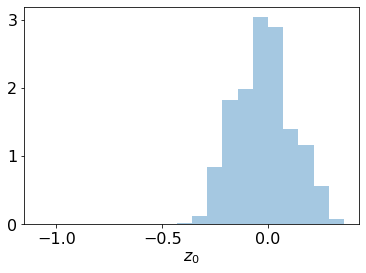

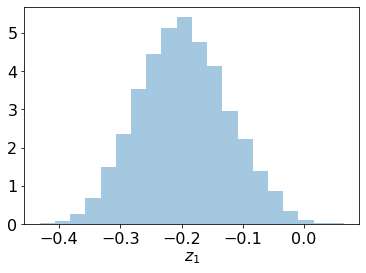

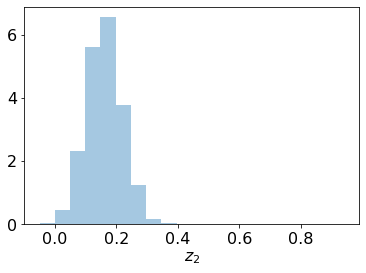

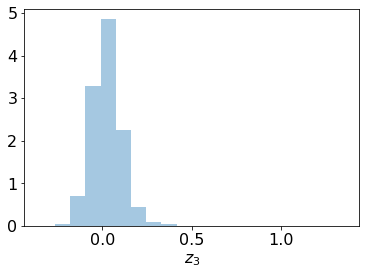

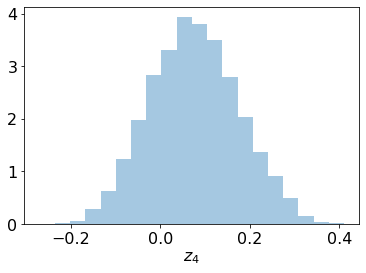

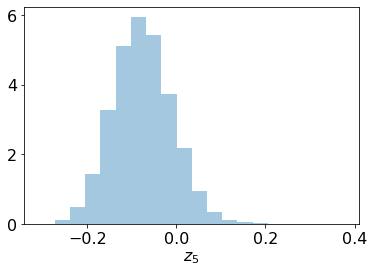

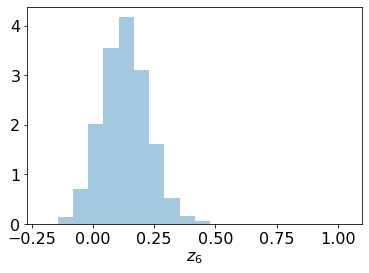

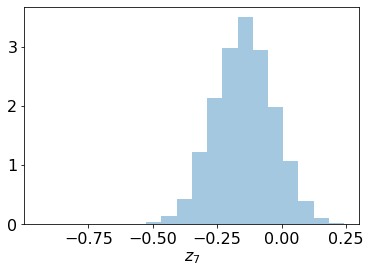

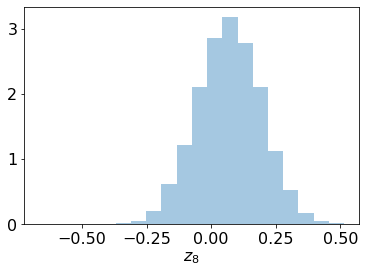

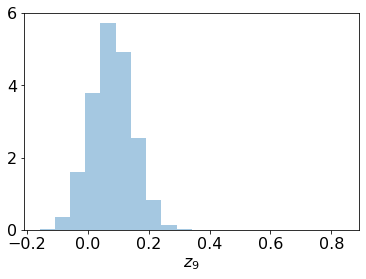

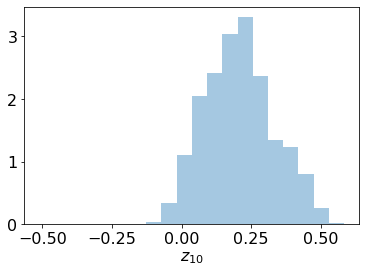

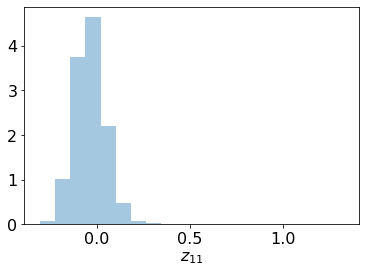

In [22]:
for i in range(z.shape[1]):
    x_aux = z[:,i]
    f = plt.figure(i)
    r = (np.min(x_aux), np.max(x_aux))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('$z_{{{}}}$'.format(i))
    dnd.append(f)

### Output features

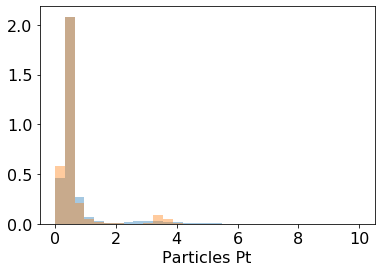

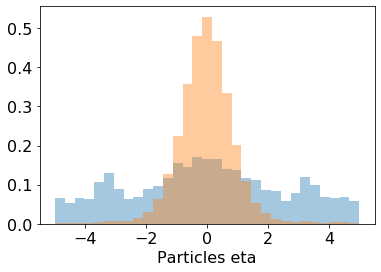

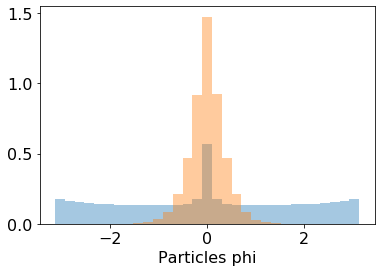

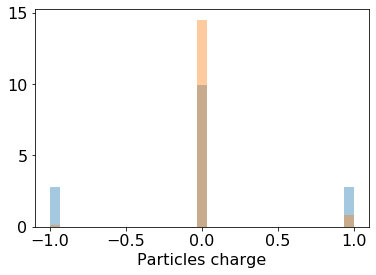

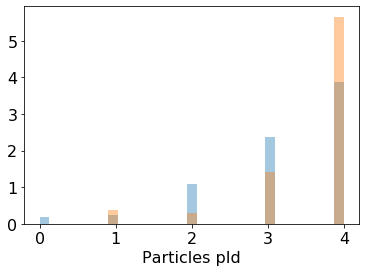

In [23]:
for i in range(x.shape[2]):
    x_aux = x[:,:,i].flatten()
    if i < 3:
        xp_aux = x_prime[:,:,i].flatten()
    elif i==3:
        xp_aux = np.argmax(x_prime[:,:,6:9], axis=2)
        xp_aux = xp_aux.flatten() - 1
    elif i==4:
        xp_aux = np.argmax(x_prime[:,:,9:14], axis=2).flatten()
        
    f = plt.figure(i)
    r = (min(np.min(x_aux), np.min(xp_aux)), max(np.max(x_aux), np.max(xp_aux)))
    if i == 0:
        r = (0,10)
    plt.hist(x_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.hist(xp_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.xlabel('Particles ' + dataset.feature_names[i])
#     plt.yscale('log')
    dnd.append(f)

# Performance evaluation

In [24]:
dataset.loadValidationSamples('SM')

Loading Wlnu (2000.0k)
Loading qcd (1141.9k)
Loading Zll (773.6k)
Loading ttbar (989.9k)
SM Mix limiting stat. sample: qcd (1.14M)
SM validation weights
[('Wlnu', 0.99999921893491114253), ('qcd', 1.0), ('Zll', 0.29257605781977745954), ('ttbar', 0.010238898454774046649)]


In [ ]:
model.eval()
for n in dataset.valSamples.keys():
    dataset.loss[n] = np.zeros((0))
    
    dataset.charge(dataset.valSamples[n])
    data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
    pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
    for i, (local_x, _) in enumerate(data_iter):
        pb.show(i)
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
            
        x_prime = model(local_x)
        z = model.encode(local_x)
        loss = criterion(local_x, x_prime, z, 'none').cpu().detach().numpy()
        dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

Ato4l: [#]  100% - Tot. time: 0.0 s
leptoquark: [######]  100% - Tot. time: 0.8 s
hToTauTau: [##############]  100% - Tot. time: 3.4 s
hChToTauNu: [#######]  100% - Tot. time: 1.2 s
Wlnu: [################----]  80% - ETA:    3 s   

In [ ]:
dic_ROC = createROC_curve(dataset)
pickle.dump(dic_ROC, open('data/dAE_v{}_ROC_dic.pkl'.format(AEversion), 'wb'))

In [ ]:
f_ROC, ax_arr = plt.subplots(2,2, figsize=(12,12))
for i, n in enumerate(dataset.BSM_names):
    f = open('../data/HLFref1811-10276_loss/VAE_all-in-one_v71_ROC1_dict_{}.pkl'.format(n), 'br')
    dRef = pickle.load(f, encoding='bytes')
    f.close()
    
    ax = ax_arr[int(i/2),i%2]
    ax.plot(dRef[b'eff_SM'], dRef[b'eff_BSM'], label=dataset.process_labels[n] + ' HLF',
            linestyle='--', lw=3, color=dataset.process_colors[n])
    ax.plot(dic_ROC[n]['eff_SM'], dic_ROC[n]['eff_BSM'], label=dataset.process_labels[n] + ' PF',
            linestyle='-', lw=3, color=dataset.process_colors[n])
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':')
    ax.set_xlim([1e-6, 1.0])
    ax.set_ylim([1e-6, 1.05])
    ax.set_xlabel('SM efficiency')
    ax.set_ylabel('BSM efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid()
    
    ax.legend(loc='lower right')
    
f_ROC.tight_layout()

## Latent dimension clustering

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
dataset.encoded = {}

for n in dataset.BSM_names:    
    dataset.charge(dataset.valSamples[n][:10000])
    x_in = torch.Tensor(dataset.inputs)
    if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
    dataset.encoded[n] = model.encode(x_in).cpu().detach().numpy()
    
dataset.charge(dataset.SMMix_val[:10000])
x_in = torch.Tensor(dataset.inputs)
if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
dataset.encoded['SMMix'] = model.encode(x_in).cpu().detach().numpy()

In [ ]:
idx_max = 1000 #np.min(list(map(lambda x: x.shape[0], dataset.encoded.values())))
z_dset = np.zeros((0, model.Nk))

for n in dataset.encoded.keys():
    z_dset = np.concatenate((z_dset, dataset.encoded[n][:idx_max]))
    
z_embedded = TSNE(n_components=2).fit_transform(z_dset)

In [ ]:
f = plt.figure(figsize=(8,8))

for i, n in enumerate(dataset.encoded.keys()):
#     if not n in ['Ato4l', 'SMMix']: continue
    aux_z = z_embedded[i*idx_max: (i+1)*idx_max]
    plt.plot(aux_z[:,0], aux_z[:,1], 
             'o',
             color=dataset.process_colors[n], 
             mfc='none',
             label=dataset.process_labels[n])
    
plt.xlabel('Embedded 0')
plt.ylabel('Embedded 1')
plt.legend(loc='best')
f.tight_layout()